# Fitting Anisotropic Power Diagrams to Grain Maps

In [1]:
# relevant libraries
import PyAPD
from pykeops.torch import LazyTensor
import copy
import torch
import matplotlib.pyplot as plt

from torchmin import minimize as minimize_torch

# typical setup
device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


#### To check that the approach works, we will first create a small artificial 2D grain map using `PyAPD`:

Precision loss detected!
Percentage error =  95.62935638427734
Lloyds iteration: 0
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 1
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 2
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 3
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 4
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 5
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 6
Optimality condition successfully overwritten.
The APD is optimal!
Percentage error =  0.9365975856781006
Lloyds iteration: 7
Optimality condition successfully o

(<Figure size 756x756 with 1 Axes>, <Axes: >)

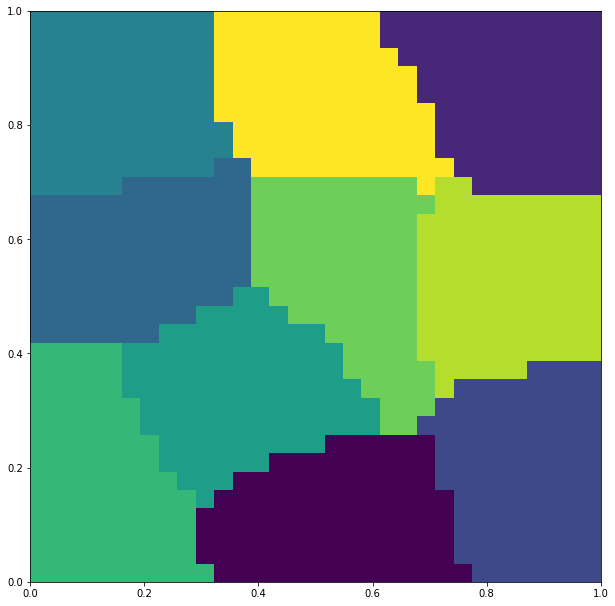

In [2]:
N = 10 # number of grains
apd1 = PyAPD.apd_system(
    N = N,
    seed = 5, # fix random seed
    pixel_size_prefactor = 1.0
)
apd1.check_optimality()
#apd1.find_optimal_W()
apd1.Lloyds_algorithm(K=10)
apd1.plot_apd()

(<Figure size 756x756 with 1 Axes>, <Axes: >)

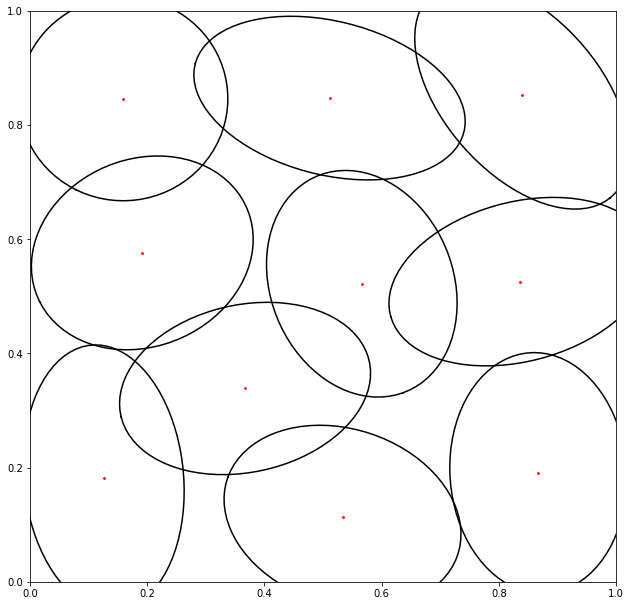

In [3]:
apd1.plot_ellipses()

In [4]:
# Save the data:
W_true = copy.deepcopy(apd1.W.contiguous())
As_true = copy.deepcopy(apd1.As.contiguous())
X_true = copy.deepcopy(apd1.X.contiguous())

# Save the grain map:
Y = copy.deepcopy(apd1.Y)
II = copy.deepcopy(apd1.assemble_apd())
II = II + 1
y = LazyTensor(Y.view(1, len(Y), 2))
print("We have ", len(Y), " pixels and ", N, " grains.")

We have  961  pixels and  10  grains.


## Reduced approach: fitting $W$

#### Equipped with the grain map, as a warm up let us try to use the approach to recover $W$. For this we do not need to rescale the variables, so we just proceed as follows:

In [29]:
eps = 1e-4 # regularisation parameter
gtol_scalar = 1e-4

In [30]:
def objective_function(X,A,W):
    dims = A.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(A,0,II-1), torch.index_select(X, 0, II-1) - Y)
    sD_ij = torch.einsum('bj,bj->b',MV,torch.index_select(X,0,II-1)-Y) - torch.index_select(W, 0, II-1)
    first_sum = (-sD_ij/eps).sum()

    a = LazyTensor(A.view(dims[0], 1, dims[1] * dims[2]))
    w = LazyTensor(W.view(dims[0],1,1))
    x = LazyTensor(X.view(dims[0], 1, dims[1]))
    D_ij = ((y - x) | a.matvecmult(y - x)) - w
    second_sum = (-D_ij/eps).logsumexp(dim=0).sum(dim=0)
    return -eps*(first_sum - second_sum)

# Defining the convex function to be optmised:
fun_red = lambda W : objective_function(X_true,As_true, W)

In [32]:
gtol = gtol_scalar*torch.ones(N).to(device=device) # optimality condition (can be passed as vector!)

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':100,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

#solver = 'cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun_red, torch.zeros(N), method=solver, disp= 3,
                             options=defaultKwargs)

W_approx = res.x

Optimality condition successfully overwritten.
initial fval: 0.2138
iter   1 - fval: 0.0606
iter   2 - fval: 0.0196
iter   3 - fval: 0.0041
iter   4 - fval: 0.0027
iter   5 - fval: 0.0006
iter   6 - fval: 0.0005
iter   7 - fval: 0.0002
iter   8 - fval: 0.0002
iter   9 - fval: 0.0001
iter  10 - fval: 0.0001
iter  11 - fval: 0.0001
iter  12 - fval: 0.0001
iter  13 - fval: 0.0001
iter  14 - fval: 0.0001
iter  15 - fval: 0.0001
iter  16 - fval: 0.0001
iter  17 - fval: 0.0001
iter  18 - fval: 0.0001
iter  19 - fval: 0.0001
iter  20 - fval: 0.0001
iter  21 - fval: 0.0001
iter  22 - fval: 0.0001
iter  23 - fval: 0.0001
iter  24 - fval: 0.0001
iter  25 - fval: 0.0001
iter  26 - fval: 0.0001
iter  27 - fval: 0.0001
iter  28 - fval: 0.0001
iter  29 - fval: 0.0001
iter  30 - fval: 0.0001
iter  31 - fval: 0.0001
iter  32 - fval: 0.0001
iter  33 - fval: 0.0001
iter  34 - fval: 0.0001
iter  35 - fval: 0.0001
iter  36 - fval: 0.0001
iter  37 - fval: 0.0001
iter  38 - fval: 0.0001
iter  39 - fval: 0.0

In [33]:
res.grad

tensor([ 6.1722e-03, -1.3626e-02,  7.7820e-04, -4.7836e-03,  2.1309e-02,
         1.2650e-02, -4.5776e-05, -3.2814e-02,  1.0757e-03,  9.2773e-03])

In [34]:
print(fun_red(W_approx))
print(fun_red(W_true))

tensor([8.9062e-05])
tensor([0.0002], grad_fn=<MulBackward0>)


Number of misassigned pixels:  tensor(0)
Proportion of misassigned pixels:  tensor(0.)


Text(0.5, 1.0, 'Misalligned pixels')

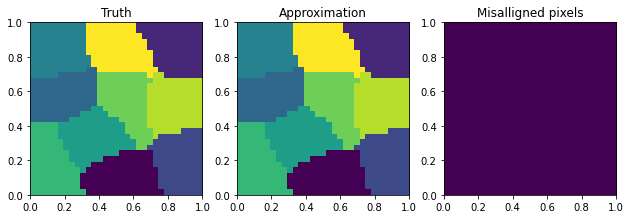

In [35]:
# Check how many pixels are assisgned to different grains
# when comparing the optimal W and the heuristic W:
apd1.set_W(W = W_true)
img_true = copy.deepcopy(apd1.assemble_apd())
apd1.set_W(W = W_approx)
img_approx = copy.deepcopy(apd1.assemble_apd())

difff = sum(torch.abs(img_true - img_approx) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

apd1.set_W(W = W_true) # reset weights to the optimum

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### All seems to work pretty well!

## Full approach: Fitting $X$, $\Lambda$ and $W$ at the same time

#### First let us try a naive approach where we do not worry too much about the matrices $\mathbf{A}_i$ being positive definite, but only with them being symmetric. That way each matrix only gives three variables $a_{i,11}$, $a_{i,22}$ and $a_{i,12}$. We thus have a flat variable
$$
\theta = \{(x_{i,1}, x_{i,2}, a_{i,11}, a_{i,22}, a_{i,12}, w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$
#### and e.g. we can assemble the optimum that we know:

In [36]:
theta_true = torch.cat((X_true[:,0],X_true[:,1],As_true[:,0,0],As_true[:,1,1],As_true[:,0,1],W_true))
theta_true.shape

torch.Size([60])

#### We can also introduce the rescaled variables 
$$
\tilde \theta = \{(\tilde x_{i,1}, \tilde x_{i,2}, \tilde a_{i,11}, \tilde a_{i,22}, \tilde a_{i,12}, \tilde w_i)\}_{i=1}^N \subset \mathbb{R}^{6N}
$$

In [37]:
def rescaling(X, As, W):
    At = As/eps
    Xt = 2.0*torch.einsum('bij,bj->bi', As, X)/eps
    Wt = (W - torch.einsum('bj,bj->b',X,eps*Xt/2.0))/eps
    return Xt, At, Wt

def inverse_rescaling(Xt, At, Wt):
    As = eps*At
    X = (eps/2.0)*torch.linalg.solve(As,Xt)
    MV = torch.einsum('bij,bj->bi', As, X)
    W = eps*Wt + torch.einsum('bj,bj->b',MV,X)
    return X, As, W

In [38]:
Xt_true, At_true, Wt_true = rescaling(X_true, As_true, W_true)
thetat_true = torch.cat((Xt_true[:,0],Xt_true[:,1],At_true[:,0,0],At_true[:,1,1],At_true[:,0,1],Wt_true))

#### And the new rescaled objective is

In [39]:
def objective_function_tilde(Xt,At,Wt):
    dims = At.shape
    MV = torch.einsum('bij,bj->bi', torch.index_select(At,0,II-1), Y)
    sD_ij = torch.einsum('bj,bj->b',MV,Y) - torch.index_select(Wt, 0, II-1) - torch.einsum('bi,bi->b',torch.index_select(Xt, 0, II-1),Y)
    first_sum = (-sD_ij).sum()

    at = LazyTensor(At.view(dims[0], 1, dims[1] * dims[2]))
    wt = LazyTensor(Wt.view(dims[0],1,1))
    xt = LazyTensor(Xt.view(dims[0], 1, dims[1]))
    D_ij =  (y | at.matvecmult(y)) - wt - ((y*xt).sum(dim=2))
    second_sum = (-D_ij).logsumexp(dim=0).sum(dim=0)
    
    return -(first_sum - second_sum)

#### We also want have the ability to go from flat variables to shaped variables quickly, so here are some helper functions:

In [40]:
def As_from_scalars(a11,a22,a12):
    return torch.stack([torch.stack([a11, a12],dim=1),
                            torch.stack([a12, a22], dim=1)],dim=2)

def X_from_scalar(x1,x2):
    return torch.stack([x1,x2],dim=1)

def from_theta_to_X_A_W(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    a11 = theta[(2*N):(3*N)]
    a22 = theta[(3*N):(4*N)]
    a12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_scalars(a11,a22,a12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [41]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W(thetat_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W(theta_true)
print(torch.dist(As_test,As_true))

tensor(8.9755e-08, grad_fn=<MulBackward0>)
tensor(9.6642e-08, grad_fn=<DistBackward0>)


In [42]:
# Defining the convex function to be optmised:
def fun(thetat):
    Xt, At, Wt = from_theta_to_X_A_W(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [44]:
# Sanity check
print(eps*fun(thetat_true),fun_red(W_true))

tensor([0.0002], grad_fn=<MulBackward0>) tensor([0.0002], grad_fn=<MulBackward0>)


In [65]:
(gtol_scalar/eps)

1.0

In [45]:
gtol = (gtol_scalar/eps)*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

#thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
#                            ((eps)**(-1.0))*torch.ones(N),((eps)**(-1.0))*torch.ones(N), torch.zeros(N),
#                            torch.zeros(N)))

thetat_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            torch.ones(N),torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun(thetat_initial)

tensor([4463989.])

In [60]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0.0, 'disp': 2, 'max_iter':10000}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 3,
                 'max_iter':100,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun, thetat_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 4463989.0000
iter   1 - fval: 2536307.0000
iter   2 - fval: 2444617.0000
iter   3 - fval: 1768284.0000
iter   4 - fval: 1552809.0000
iter   5 - fval: 1339801.0000
iter   6 - fval: 1100111.0000
iter   7 - fval: 990319.0000
iter   8 - fval: 901857.0000
iter   9 - fval: 667157.0000
iter  10 - fval: 608396.0000
iter  11 - fval: 462872.0000
iter  12 - fval: 326706.0000
iter  13 - fval: 220268.0000
iter  14 - fval: 159152.0000
iter  15 - fval: 125292.0000
iter  16 - fval: 99759.0000
iter  17 - fval: 70745.0000
iter  18 - fval: 55798.0000
iter  19 - fval: 42442.0000
iter  20 - fval: 36328.0000
iter  21 - fval: 33187.0000
iter  22 - fval: 29258.0000
iter  23 - fval: 23540.0000
iter  24 - fval: 18621.0000
iter  25 - fval: 12390.0000
iter  26 - fval: 7909.0000
iter  27 - fval: 7023.0000
iter  28 - fval: 6001.0000
iter  29 - fval: 5501.0000
iter  30 - fval: 5049.0000
iter  31 - fval: 4784.0000
iter  32 - fval: 4643.0000
iter  33 - fval:

In [61]:
res.grad

tensor([-0.1862, -0.5778,  0.1036,  0.3269, -0.2302,  0.3392, -0.0055,  0.0428,
        -0.2091,  0.3962, -0.0730, -0.5558, -0.0415,  0.4979,  0.1362, -0.0140,
        -0.0094,  0.3909, -0.2612, -0.0701, -0.0401,  0.4271, -0.2322, -0.0409,
         0.0560, -0.0873,  0.0012, -0.1367,  0.2703, -0.2173, -0.0182,  0.4377,
         0.0106, -0.3455, -0.2183,  0.0350,  0.0037, -0.3162,  0.1628,  0.2483,
        -0.0683,  0.8138, -0.0674, -0.4340,  0.2068, -0.0225,  0.0028, -0.4785,
         0.3855, -0.3383, -0.9620, -0.7647, -0.0367,  0.8739,  0.0160,  0.7537,
        -0.0302,  0.0635, -0.2126,  0.2992])

In [62]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [63]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(),
                        As = As_approx.contiguous(),
                        W = W_approx2.contiguous(),
                        pixel_size_prefactor = 1.0,
                       )

Number of misassigned pixels:  tensor(34)
Proportion of misassigned pixels:  tensor(0.0354)


Text(0.5, 1.0, 'Misalligned pixels')

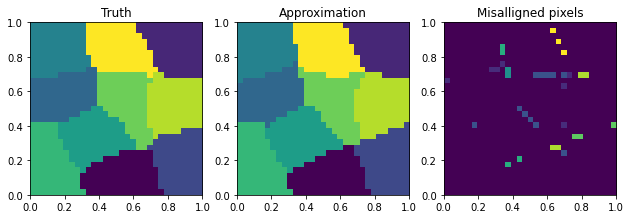

In [64]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

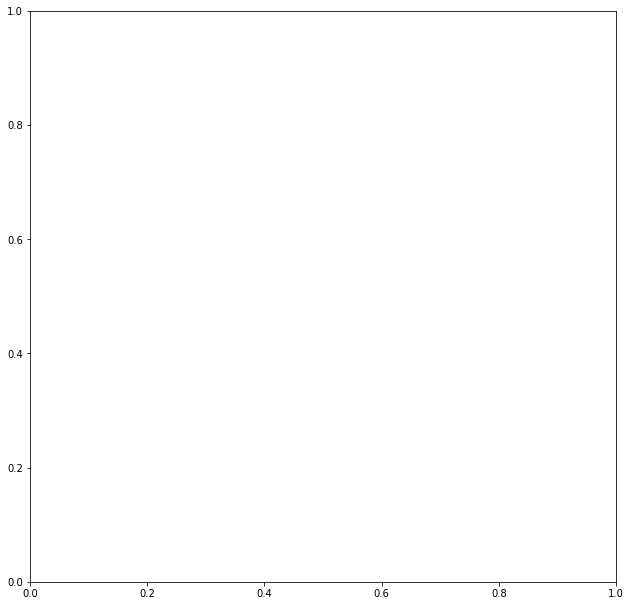

In [66]:
apd2.plot_ellipses()

In [67]:
torch.linalg.det(apd2.As)

tensor([-0.2121, -0.0764, -0.0690, -0.0161, -0.0533, -0.0681, -0.0312, -0.0238,
        -0.0220, -0.2271])

#### Not caring about positive definiteness of the matrices seems to affect things, which can be seen e.g. by restarting the optimisation procedure at a better initial guess:

In [69]:
print("The found optimum: ", fun(res.x))
print("The known actual optimum: ", fun(thetat_true))

The found optimum:  tensor([912.])
The known actual optimum:  tensor([2.0469], grad_fn=<NegBackward0>)


In [70]:
res2 = PyAPD.minimize_torch(fun, thetat_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 2.0469
iter   1 - fval: 1.7500
Optimization terminated successfully.
         Current function value: 1.750000
         Iterations: 1
         Function evaluations: 2


In [71]:
Xt_approx, At_approx, Wt_approx = from_theta_to_X_A_W(res2.x)
X_approx, As_approx, W_approx2 = inverse_rescaling(Xt_approx, At_approx, Wt_approx)

In [72]:
torch.linalg.det(As_approx)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [75]:
apd2 = PyAPD.apd_system(X = X_approx.contiguous(),
                        As = As_approx.contiguous(),
                        W = W_approx2.contiguous(),
                        pixel_size_prefactor=1,
                       )

Number of misassigned pixels:  tensor(0)
Proportion of misassigned pixels:  tensor(0.)


Text(0.5, 1.0, 'Misalligned pixels')

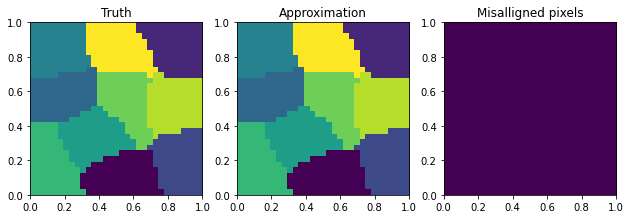

In [76]:
img_approx2 = copy.deepcopy(apd2.assemble_apd())

difff = sum(torch.abs(img_true - img_approx2) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx2.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx2).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

#### Another issues worth thinking about is the interplay and redundancies with respect to $X$, $\Lambda$ and $W$, e.g. the determinant of matrices, the shifting of weights by a constant etc.

## Less naive approach

In [77]:
def As_from_cholesky(l11,l22,l12):
    L = torch.stack([torch.stack([l11, l12],dim=1),
                            torch.stack([torch.zeros(len(l11)), l22], dim=1)],dim=2)
    return L @ torch.transpose(L,1,2)

In [78]:
def from_theta_to_X_A_W_cholesky(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    l22 = theta[(3*N):(4*N)]
    l12 = theta[(4*N):(5*N)]
    Wt = theta[(5*N):(6*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [79]:
Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_true = torch.cat((X_true[:,0],X_true[:,1],Ls_true[:,0,0],Ls_true[:,1,1],Ls_true[:,1,0],W_true))
theta_cholesky_true.shape

torch.Size([60])

In [80]:
Lt_true = Ls_true/(eps**(0.5))

thetat_cholesky_true = torch.cat((Xt_true[:,0],Xt_true[:,1],Lt_true[:,0,0],Lt_true[:,1,1], Lt_true[:,1,0],Wt_true))
thetat_cholesky_true.shape

torch.Size([60])

In [81]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky(thetat_cholesky_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky(theta_cholesky_true)
print(torch.dist(As_test,As_true))

tensor(5.3249e-07, grad_fn=<MulBackward0>)
tensor(3.5075e-07, grad_fn=<DistBackward0>)


In [82]:
# Defining the convex function to be optmised:
def fun_cholesky(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [83]:
# Sanity check
print(eps*fun(thetat_true), eps*fun_cholesky(thetat_cholesky_true),fun_red(W_true))

tensor([0.0002], grad_fn=<MulBackward0>) tensor([0.0002], grad_fn=<MulBackward0>) tensor([0.0002], grad_fn=<MulBackward0>)


In [85]:
gtol = (gtol_scalar/eps)*torch.ones(6*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.25))*torch.ones(N),((eps)**(-0.25))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky(thetat_cholesky_initial)

tensor([5308585.])

In [107]:
#solver = 'bfgs'
#defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

solver = 'bfgs'
defaultKwargs = {'gtol': gtol,
                 'xtol': -1e-10,
                 'disp': 1,
                 'max_iter':500,
                 #'line_search': 'none',
                 #'lr': 1e-1,
                }

res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_initial, method=solver,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
Maximum number of iterations has been exceeded.
         Current function value: 60672.000000
         Iterations: 500
         Function evaluations: 3906


In [108]:
res.grad

tensor([-4.3304e+00,  2.9302e+00, -2.7933e-01, -2.7426e+00,  3.8459e-01,
         4.3337e+00, -2.3255e+00, -5.9663e-01, -1.4962e+00,  4.1221e+00,
         1.9547e-02,  3.0331e+00, -4.3741e-01, -9.7855e+00,  5.8481e+00,
        -8.0484e-01,  9.5388e-02, -4.2689e+00, -8.8882e-01,  7.1892e+00,
        -3.3513e+02, -1.9274e+03, -1.2614e+02,  1.1692e+03, -6.8995e+02,
        -3.9002e+02, -1.3574e+02,  4.2789e+03,  8.1496e+01, -2.0376e+03,
         4.0850e+01, -7.0880e+02,  1.2194e+02,  7.3727e+03, -5.4949e+03,
        -4.2705e+02,  2.7280e+01, -2.5487e+02, -9.5965e+01,  5.1464e+03,
        -1.1304e+02, -1.5540e+03, -6.6866e+01,  3.1706e+03, -3.1677e+03,
        -4.0015e+02, -1.2422e+02,  6.4709e+03,  1.9731e+02, -3.3875e+03,
         5.0170e+00,  5.9526e+00, -1.0071e+00, -1.8780e+01,  1.0377e+01,
         4.9565e+00, -1.6009e+01, -2.6093e-01, -2.9546e+00,  1.2710e+01])

In [109]:
Xt_approx3, At_approx3, Wt_approx3 = from_theta_to_X_A_W_cholesky(res.x)
X_approx3, As_approx3, W_approx3 = inverse_rescaling(Xt_approx3, At_approx3, Wt_approx3)

In [110]:
torch.linalg.det(As_approx3)

tensor([1.7735e-01, 8.4972e+00, 2.4315e-01, 2.0541e+02, 1.0225e+02, 3.8912e+01,
        3.6880e+00, 7.0559e-02, 6.0343e+00, 1.0669e+02])

In [111]:
apd3 = PyAPD.apd_system(X = X_approx3.contiguous(),
                        As = As_approx3.contiguous(),
                        W = W_approx3.contiguous(),
                       pixel_size_prefactor=1)

Number of misassigned pixels:  tensor(180)
Proportion of misassigned pixels:  tensor(0.1873)


Text(0.5, 1.0, 'Misalligned pixels')

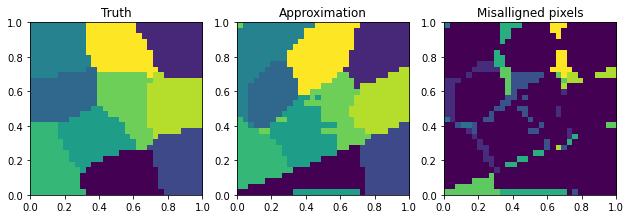

In [112]:
img_approx3 = copy.deepcopy(apd3.assemble_apd())

difff = sum(torch.abs(img_true - img_approx3) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx3.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx3).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

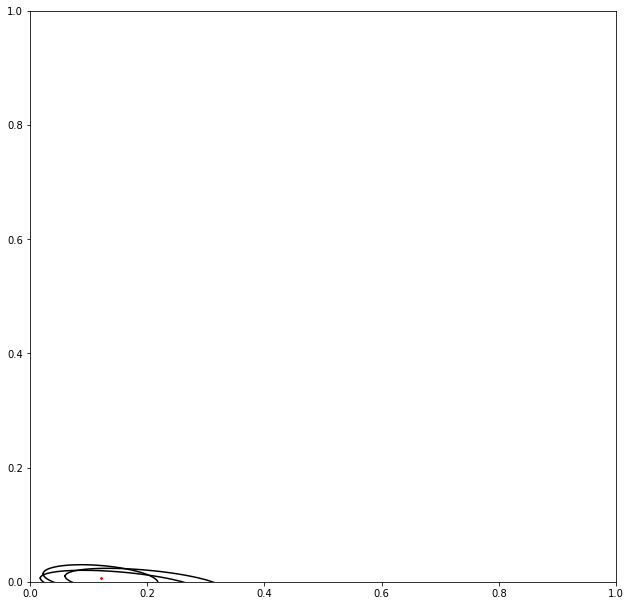

In [98]:
apd3.plot_ellipses()

In [99]:
res = PyAPD.minimize_torch(fun_cholesky, thetat_cholesky_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
Maximum number of iterations has been exceeded.
         Current function value: 0.765625
         Iterations: 200
         Function evaluations: 1325


## Keeping determinant fixed

In [113]:
def from_theta_to_X_A_W_cholesky_red(theta):
    x1 = theta[0:N]
    x2 = theta[N:(2*N)]
    l11 = theta[(2*N):(3*N)]
    #l22 = theta[(3*N):(4*N)]
    l22 = 1.0/(eps*l11)
    l12 = theta[(3*N):(4*N)]
    Wt = theta[(4*N):(5*N)]
    At = As_from_cholesky(l11,l22,l12)
    Xt = X_from_scalar(x1,x2)
    return Xt, At, Wt

In [114]:
#Ls_true = torch.linalg.cholesky(As_true)
theta_cholesky_red_true = torch.cat((X_true[:,0],X_true[:,1],Ls_true[:,0,0],Ls_true[:,1,0],W_true))
theta_cholesky_red_true.shape

torch.Size([50])

In [115]:
thetat_cholesky_red_true = torch.cat((Xt_true[:,0],Xt_true[:,1],Lt_true[:,0,0],Lt_true[:,1,0],Wt_true))
thetat_cholesky_red_true.shape

torch.Size([50])

In [116]:
# Some sanity checks:

_, At_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_true)
print(eps*torch.dist(At_test,At_true))

_, As_test, _ = from_theta_to_X_A_W_cholesky_red(theta_cholesky_red_true)
print(torch.dist(As_test,As_true)) # that's fine for now

tensor(5.6083e-07, grad_fn=<MulBackward0>)
tensor(3.5169e+08, grad_fn=<DistBackward0>)


In [117]:
# Defining the convex function to be optmised:
def fun_cholesky_red(thetat):
    Xt, At, Wt = from_theta_to_X_A_W_cholesky_red(thetat)
    return objective_function_tilde(Xt,At,Wt)

In [118]:
# Sanity check
print(fun(thetat_true), fun_cholesky(thetat_cholesky_true),fun_cholesky_red(thetat_cholesky_red_true))

tensor([2.0469], grad_fn=<NegBackward0>) tensor([2.0156], grad_fn=<NegBackward0>) tensor([2.0469], grad_fn=<NegBackward0>)


In [119]:
gtol = (gtol_scalar/eps)*torch.ones(5*N).to(device=device)
Xt_initial = PyAPD.sample_seeds_with_exclusion(N,
                                               dim=2,
                                               radius_prefactor = apd1.radius_of_exclusion,
                                               verbose = False).to(device=apd1.device, dtype=apd1.dt)

Xt_initial = 2.0*(apd1.domain[:,0] + (apd1.domain[:,1]-apd1.domain[:,0]) * Xt_initial)/eps

thetat_cholesky_red_initial = torch.cat((Xt_initial[:,0],Xt_initial[:,1],
                            ((eps)**(-0.5))*torch.ones(N), torch.zeros(N),
                            torch.zeros(N)))

fun_cholesky_red(thetat_cholesky_red_initial)

tensor([7148005.])

In [120]:
_, At_initial_test, _ = from_theta_to_X_A_W_cholesky_red(thetat_cholesky_red_initial)
torch.linalg.det(At_initial_test)

tensor([100000000., 100000000., 100000000., 100000000., 100000000., 100000000.,
        100000000., 100000000., 100000000., 100000000.])

In [121]:
At_initial_test[0]

tensor([[10000.,     0.],
        [    0., 10000.]])

In [122]:
solver = 'bfgs'
defaultKwargs = {'gtol': gtol, 'xtol': 0, 'disp': 2, 'max_iter':10000}

#solver = 'newton-cg'
#defaultKwargs = {'xtol': 0, 'disp': 2, 'max_iter':10}

res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_initial, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 7148005.0000
iter   1 - fval: 4306730.0000
iter   2 - fval: 2759235.0000
iter   3 - fval: 2463237.0000
iter   4 - fval: 2148193.0000
iter   5 - fval: 1982283.7500
iter   6 - fval: 1897836.5000
iter   7 - fval: 1678190.5000
iter   8 - fval: 1542174.5000
iter   9 - fval: 1498632.5000
iter  10 - fval: 1343186.7500
iter  11 - fval: 1291043.3750
iter  12 - fval: 1250752.5000
iter  13 - fval: 1207443.1250
iter  14 - fval: 1131895.5000
iter  15 - fval: 1099226.7500
iter  16 - fval: 1088704.5000
iter  17 - fval: 1073937.2500
iter  18 - fval: 1050335.7500
iter  19 - fval: 1030784.7500
iter  20 - fval: 976594.2500
iter  21 - fval: 936660.1250
iter  22 - fval: 903304.2500
iter  23 - fval: 839290.8750
iter  24 - fval: 776284.1250
iter  25 - fval: 750423.5000
iter  26 - fval: 717858.5000
iter  27 - fval: 701420.5000
iter  28 - fval: 690720.2500
iter  29 - fval: 668004.2500
iter  30 - fval: 653980.5000
iter  31 - fval: 618097.2500
iter  32

In [123]:
Xt_approx4, At_approx4, Wt_approx4 = from_theta_to_X_A_W_cholesky_red(res.x)
X_approx4, As_approx4, W_approx4 = inverse_rescaling(Xt_approx4, At_approx4, Wt_approx4)

In [124]:
torch.linalg.det(As_approx4)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [127]:
apd4 = PyAPD.apd_system(X = X_approx4.contiguous(),
                        As = As_approx4.contiguous(),
                        W = W_approx4.contiguous(),
                        pixel_size_prefactor=1,
                       )

Number of misassigned pixels:  tensor(491)
Proportion of misassigned pixels:  tensor(0.5109)


Text(0.5, 1.0, 'Misalligned pixels')

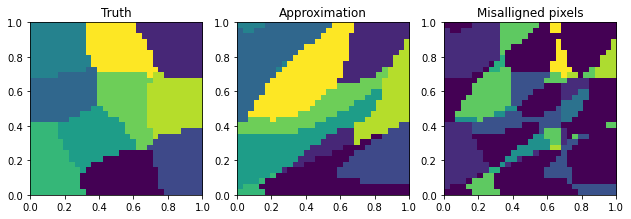

In [128]:
img_approx4 = copy.deepcopy(apd4.assemble_apd())

difff = sum(torch.abs(img_true - img_approx4) > 0.5)

print("Number of misassigned pixels: ",difff)
print("Proportion of misassigned pixels: ",difff / img_true.shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(10.5, 30.5, forward=True)

ax1.imshow(img_true.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax1.set_title('Truth')
ax2.imshow(img_approx4.reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax2.set_title('Approximation')
ax3.imshow(torch.abs(img_true - img_approx4).reshape(apd1.pixel_params).transpose(0,1).cpu(), origin='lower', extent = torch.flatten( apd1.domain ).tolist())
ax3.set_title('Misalligned pixels')

(<Figure size 756x756 with 1 Axes>, <Axes: >)

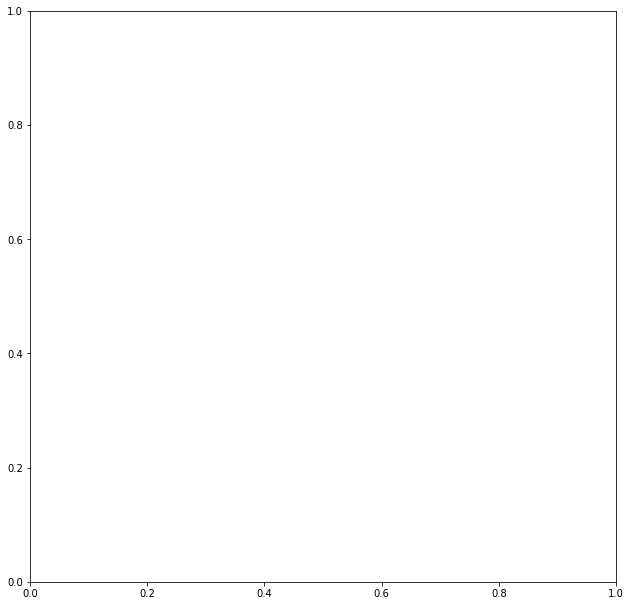

In [129]:
apd4.plot_ellipses()

In [57]:
res = PyAPD.minimize_torch(fun_cholesky_red, thetat_cholesky_red_true, method=solver, disp= 2,
                             options=defaultKwargs)

Optimality condition successfully overwritten.
initial fval: 41.0078
iter   1 - fval: 40.1641
iter   2 - fval: 39.5156
iter   3 - fval: 39.3203
iter   4 - fval: 38.9219
iter   5 - fval: 38.8359
iter   6 - fval: 38.7891
iter   7 - fval: 38.7344
iter   8 - fval: 38.6797
iter   9 - fval: 38.6094
iter  10 - fval: 38.5234
iter  11 - fval: 38.4453
iter  12 - fval: 38.3672
iter  13 - fval: 38.2969
iter  14 - fval: 38.1953
iter  15 - fval: 38.0625
iter  16 - fval: 37.9297
iter  17 - fval: 37.8672
iter  18 - fval: 37.8438
iter  19 - fval: 37.8281
iter  20 - fval: 37.8125
iter  21 - fval: 37.7969
iter  22 - fval: 37.7734
iter  23 - fval: 37.7656
iter  24 - fval: 37.7500
iter  25 - fval: 37.7500
Optimization terminated successfully.
         Current function value: 37.750000
         Iterations: 25
         Function evaluations: 27


In [102]:
import numpy as np

In [104]:
np.exp(-1/eps)

0.0